# Bayesian network for COVID-19 vaccines adverse reactions
### *Fundamentals of Artificial Intelligence and Knowledge Representation - Module 3*
#### *Alma Mater Studiorum Università di Bologna - a.a 20/21*

##### **Author:** [Emmanuele Bollino](https://www.linkedin.com/in/emmanuele-bollino/)

> **WARNING** All the data used in this project are taken from the [VAERS](https://wonder.cdc.gov/vaers.html) database managed by [CDC](https://www.cdc.gov/).
>
> This project is intended for research purposes only. CDC reserves all the rights for these data.

## Abstract
This project was developed in June 2021 during the COVID-19 outbreak. In this period the governments from all around the world
are doing massive vaccination campaigns. There are several manufacturers of vaccines, and some people are facing with
side effects caused by vaccine injections. Most of the side effects are self solving but in this period there is an
open debate about the safety of these vaccines.

This project deals with vaccine adverse events reported in the U.S.A. on the [VAERS](https://wonder.cdc.gov/vaers.html)
database that contains the adverse events of vaccines in the U.S.A. from 1990.

The aim of this project is to study the correlation between some factors and the gravity of the adverse events of COVID-19
vaccines. Given some risk-factors and other information about the injection, we want to determine the probability of
having a serious adverse reaction. Because of the lack of non-adverse events, all the considerations are done considering
that the patient has for sure an adverse reaction.

For the sake of simplicity, data contained in the database have hardly been simplified, loosing important information
about the domain. Because of this, the results are considered over simplistic and not reliable. This project only shows
that using probabilistic graphical models for this domain is possible.

## Data
As previously mentioned, data are taken from [VAERS](https://wonder.cdc.gov/vaers.html) but only from 2021. So, from the
beginning of 2021 to June 2021.

All the data are managed using Pandas.

### Import
Data are in CSV form and on multiple files linked by and ID.

In [130]:
import pandas as pd

general_data_path = 'data/2021VAERSDATA.csv'
vax_data_path = 'data/2021VAERSVAX.csv'

data_general = pd.read_csv(general_data_path)
data_vax = pd.read_csv(vax_data_path)

data_full = pd.merge(data_general, data_vax, on='VAERS_ID')

data_full.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7,12,23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,OFC_VISIT,ER_ED_VISIT,ALLERGIES,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
0,916600,01/01/2021,TX,33.0,33.0,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,...,Y,NaN,Pcn and bee venom,COVID19,MODERNA,037K20A,1,IM,LA,COVID19 (COVID19 (MODERNA))
1,916601,01/01/2021,CA,73.0,73.0,NaN,F,NaN,Approximately 30 min post vaccination administ...,NaN,...,Y,NaN,"""Dairy""",COVID19,MODERNA,025L20A,1,IM,RA,COVID19 (COVID19 (MODERNA))
2,916602,01/01/2021,WA,23.0,23.0,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",NaN,...,NaN,Y,Shellfish,COVID19,PFIZER\BIONTECH,EL1284,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH))
3,916603,01/01/2021,WA,58.0,58.0,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",NaN,...,NaN,NaN,"Diclofenac, novacaine, lidocaine, pickles, tom...",COVID19,MODERNA,unknown,UNK,NaN,NaN,COVID19 (COVID19 (MODERNA))
4,916604,01/01/2021,TX,47.0,47.0,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",NaN,...,NaN,NaN,Na,COVID19,MODERNA,NaN,1,IM,LA,COVID19 (COVID19 (MODERNA))


There are several columns. Each column contains information about the adverse reaction, the patient and the injection.
The full description of each column is available [here](https://vaers.hhs.gov/docs/VAERSDataUseGuide_November2020.pdf).

In [131]:
data_full.columns

Index(['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX',
       'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
       'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY',
       'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE',
       'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT',
       'ALLERGIES', 'VAX_TYPE', 'VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES',
       'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME'],
      dtype='object')

There's also plenty of rows. Each record represents an adverse reaction happened to a patient.

In [132]:
data_full.shape[0]

326435

### Filtering
Data are filtered for the type of vaccine (COVID-19), and some columns are removed for the sake of simplicity and significance.

In [133]:
interesting_columns = ['CAGE_YR',
                       'SEX',
                       'DIED',
                       'L_THREAT',
                       'ER_VISIT',
                       'HOSPITAL',
                       'DISABLE',
                       'CUR_ILL',
                       'HISTORY',
                       'PRIOR_VAX',
                       'ALLERGIES',
                       'VAX_MANU',
                       'VAX_DOSE_SERIES']
vax_type = 'COVID19'

data_filtered = data_full[data_full['VAX_TYPE'] == vax_type]
data_filtered = data_filtered[interesting_columns]

data_filtered.shape

(323606, 13)

### Bucketization
Some columns need to be bucketized, like the age.

In [134]:
data_bucketized = data_filtered.copy(deep=True)
data_bucketized['CAGE_YR'] = pd.cut(x=data_bucketized['CAGE_YR'],
                                    bins=[0, 7, 17, 30, 50, 65, 80, 150],
                                    labels=['Baby', 'Minor', 'Young', 'Adult', 'Upper adult', 'Old', 'Over 80'])

data_bucketized['CAGE_YR']

0               Adult
1                 Old
2               Young
3         Upper adult
4               Adult
             ...     
326430          Minor
326431    Upper adult
326432            Old
326433            Old
326434          Adult
Name: CAGE_YR, Length: 323606, dtype: category
Categories (7, object): ['Baby' < 'Minor' < 'Young' < 'Adult' < 'Upper adult' < 'Old' < 'Over 80']

### Cleaning
Data need some cleaning operations because of unknown and badly compiled values. Rows with unknown values are removed,
paying attention to the fact that for some columns, unknown values are meaningful.

In [135]:
data_clean = data_bucketized.copy(deep=True)

data_clean = data_clean[data_clean['SEX'] != 'U']

data_clean = data_clean[data_clean['VAX_MANU'] != 'UNKNOWN MANUFACTURER']

Numeric data stored as string are converted into numbers, so that the order is kept.

In [136]:
# only doses <= 4 are kept
data_clean = data_clean[data_clean['VAX_DOSE_SERIES'] != 'UNK']
data_clean = data_clean[data_clean['VAX_DOSE_SERIES'] != '7+']
data_clean['VAX_DOSE_SERIES'] = pd.to_numeric(data_clean['VAX_DOSE_SERIES'])
data_clean = data_clean[data_clean['VAX_DOSE_SERIES'] <= 4]

Boolean data stored as string are converted into python booleans.

In [137]:
def yn_to_boolean(df, columns):
    modified = df
    for column in columns:
        modified = modified.replace({column: {'Y': True, 'N': False}})
        modified[column] = modified[column].fillna(False)
    return modified


data_clean = yn_to_boolean(data_clean, ['DIED', 'L_THREAT', 'ER_VISIT', 'HOSPITAL', 'DISABLE'])

### Approximation
Some columns, like allergies and illnesses, contain strings that represent a list of values. The problem is that those
values are not standardized and each person who filled the cell inserted a non-structured text. Because of the amount of
rows, it is not possible to do a precise cleaning of these fields. So, the solution adopted here is an over approximation
of those columns: we consider only if a value is empty or not, reducing the strings to booleans. In this way, every illness
is the same as the other. From now on we will only know if a patient has some previous illness or not. Moreover, if the
value is not known we naively assume that it is empty. Due to this, if a patient illness is not recorded we assume that
he is fully healthy. This process is the main reason of non-reliability of the results of this project.

In [138]:
def description_to_boolean(df, columns):
    modified = df
    for column in columns:
        modified.loc[modified[column].str.len() > 5, column] = True
        modified.loc[modified[column].str.len() <= 5, column] = False
        modified[column] = modified[column].fillna(False)
    return modified


data_approx = data_clean.copy(deep=True)
data_approx = description_to_boolean(data_approx, ['CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'ALLERGIES'])

### Aggregation
So far data have gone through several manipulations, but they still have too many columns for a bayesian network. Indeed,
if we try to make pgmpy learn the structure of the network, we will see that it is a complete mess and computational heavy.
It would be too hard for a non-physician to deal with it. That's why some aggregation between columns is needed.

The aggregation involves the final damage to the patient. Death, disability and hospitalization are combined in a single node.
This leads to a degradation of the knowledge because there could have been the case that more than one of these fields
were true. In this way we're taking only the most serious damage. We also assume that if none of these fields were active,
it means that the adverse reaction self-solved.

In [139]:
def calculate_damage(row):
    if row['DIED'] or row['L_THREAT']:
        return 'Died or almost'
    elif row['DISABLE']:
        return 'Disability'
    elif row['HOSPITAL']:
        return 'Medium'
    else:
        return 'Self-solving'


data_agg = data_approx.copy(deep=True)
data_agg['DAMAGE'] = data_agg.apply(lambda row: calculate_damage(row), axis=1)
data_agg['ILLNESS'] = data_agg.apply(lambda row: row['CUR_ILL'] or row['HISTORY'], axis=1)
data_agg.drop(['DIED', 'L_THREAT', 'DISABLE', 'HOSPITAL', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX'], axis=1, inplace=True)

### Renaming
This is the concluding part. For the sake of readability, some columns are renamed into a more human-readable way.

In [140]:
data = data_agg.copy(deep=True)
data = data.rename(columns={'CAGE_YR': 'AGE', 'VAX_MANU': 'MANU', 'VAX_DOSE_SERIES': 'DOSE', 'ER_VISIT': 'VISIT'})

In [141]:
data.head()

,AGE,SEX,VISIT,ALLERGIES,MANU,DOSE,DAMAGE,ILLNESS
0,Adult,F,False,True,MODERNA,1.0,Self-solving,False
1,Old,F,False,True,MODERNA,1.0,Self-solving,True
2,Young,F,False,True,PFIZER\BIONTECH,1.0,Self-solving,False
4,Adult,F,False,False,MODERNA,1.0,Self-solving,False
6,Adult,F,False,True,MODERNA,1.0,Self-solving,False


In [142]:
data.shape

(261556, 8)

Each row contains data about a reported adverse reaction. It contains data about the injection, the reaction and the patient.
The meaning of the columns is the following:

| Column   | Outcomes | Meaning |
|----------|:-------------:|------:|
| AGE | 'Baby', 'Minor', 'Young', 'Adult', 'Upper adult', 'Old', 'Over 80' | Patient's age |
| SEX | 'M', 'F' | Patient's sex |
| VISIT | True, False | Whether an ER visit was requested or not |
| ALLERGIES | True, False | Whether the patient has some allergies or not |
| MANU | 'MODERNA', 'PFIZER\\BIONTECH', 'JANSSEN' | Manufacturer of the injection |
| DOSE | 1, 2, 3, 4 | Dose number |
| DAMAGE | 'Died or almost', 'Disability', 'Medium' 'Self-solving' | Patient's final damage |
| ILLNESS | True, False | Whether the patient has some previous illnesses or not |

## Network structure
Now that data is ready, it's time to construct the bayesian network associated to them. The library used is pgmpy.

### Network visualization
A bayesian network is a DAG. In order to visualize the network, the networkx library is used.

In [143]:
import networkx as nx

"""
Draws a graph with the given nodes and edges.
"""
def draw_graph(nodes, edges):
    graph = nx.DiGraph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)

    options = {
        'node_size': 4200,
        'width': 2,
        'arrowstyle': '-|>',
        'arrowsize': 15,
        'with_labels': True,
        'arrows': True
    }

    nx.draw_shell(graph, **options)

### Network structure learning
The bayesian network structure is learnt using pgmpy.

Pgmpy provides search algorithms in order to find the best network. A network is evaluated on the basis of a scoring function.
In this project, Bayesian Information Criterion is used as model selection criterion. It is based on the likelihood function.

In [144]:
from pgmpy.estimators import BicScore

scoring = BicScore(data)

In [145]:
# Exhaustive search (is commented because infeasible)

#from pgmpy.estimators import ExhaustiveSearch
#exh = ExhaustiveSearch(data_agg, scoring_method = scoring)
#best_model_exh = exh.estimate()

#UserWarning: Generating all DAGs of n nodes likely not feasible for n>6!
# warn("Generating all DAGs of n nodes likely not feasible for n>6!")
#Attempting to search through 72057594037927936 graphs

The search algorithm used is a local search, in particular, it is the Hill Climb one. That's because an exhaustive search
is infeasible.

A first attempt is the following:

 24%|██▍       | 24/100 [00:14<00:44,  1.69it/s]


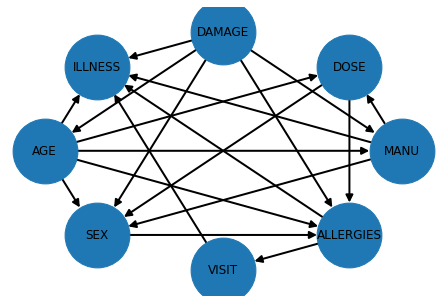

In [146]:
from pgmpy.estimators import HillClimbSearch

hcs = HillClimbSearch(data, scoring_method=scoring)
first_model = hcs.estimate(max_iter=100)

draw_graph(data.columns, first_model.edges())

This network is a complete mess. Some relations are not captured and if captured, sometimes they are in the opposite way.
Now we try to exploit a prior knowledge about the relations: fixing some edges and preventing some to be learnt.
We need fewer relations and more relevant ones.

  0%|          | 6/1000000 [00:03<156:47:31,  1.77it/s]


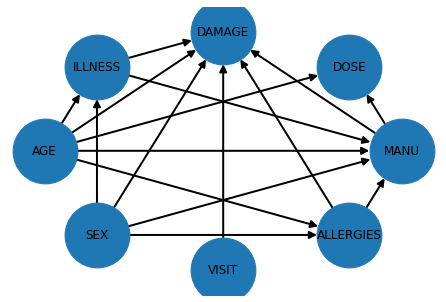

In [147]:
fixed_edges=[
    ('AGE', 'DAMAGE'),          # the adverse reaction is different in young and elderly people
    ('AGE', 'ILLNESS'),         # aging can cause illnesses
    ('AGE', 'MANU'),            # the vaccine manufacturer is chosen because of patient's age by physicians
    ('ALLERGIES', 'DAMAGE'),    # a presence of allergies can cause different types of adverse reactions
    ('ALLERGIES', 'MANU'),      # the vaccine manufacturer is chosen because of patient's age allergies by physicians
    ('ILLNESS', 'MANU'),        # the vaccine manufacturer is chosen because of patient's age illnesses by physicians
    ('ILLNESS', 'DAMAGE'),      # a presence of previous illnesses can cause different types of adverse reactions
    ('MANU', 'DAMAGE'),         # different vaccines can cause different adverse reactions
    ('SEX', 'DAMAGE'),          # patient's sex can influence the adverse reaction
    ('VISIT', 'DAMAGE'),        # a timely ER visit can influence the final damage or it can be a signal of the severity of the adverse reaction
]

black_list=[
    ('AGE', 'SEX'),             # sex is not influenced by any other factor in this context
    ('SEX', 'AGE'),             # age is not influenced by any other factor in this context
    ('VISIT', 'ALLERGIES'),     # allergies are not influenced by a visit
    ('VISIT', 'ILLNESS'),       # illnesses are not influenced by a visit
    ('VISIT', 'DOSE'),          # the dose is not influenced by a visit (which happens after)
    ('ALLERGIES', 'SEX'),       # sex is not influenced by any other factor in this context
    ('ALLERGIES', 'VISIT'),     # we assume that the visit is not influenced by allergies but a deeper analysis should be done
    ('DAMAGE', 'ILLNESS'),      # the damage from the adverse reaction can't cause illnesses
    ('DAMAGE', 'MANU'),         # the damage from the adverse reaction can't cause the manufacturer of the injection received
    ('ALLERGIES', 'ILLNESS'),   # we assume that allergies and illnesses are two completely separated entities but a deeper analysis should be done
    ('ILLNESS', 'ALLERGIES'),   # we assume that allergies and illnesses are two completely separated entities but a deeper analysis should be done
    ('ILLNESS', 'SEX'),         # sex is not influenced by any other factor in this context
]

model_wdf = hcs.estimate(fixed_edges=fixed_edges, black_list=black_list)

draw_graph(data.columns, model_wdf.edges())

## CPDs
Now that the network graph is ready, we need to fulfill it with Conditional Probability Tables.

### CPDs learning
CPDs are learnt directly from data with a bayesian estimator with the prior distribution Bayesian Dirichlet equivalent uniform.

In [148]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator

bayesian_model = BayesianModel(model_wdf.edges())
bayesian_model.fit(data, estimator=BayesianEstimator, prior_type="BDeu")

bayesian_model.check_model()

True

In [149]:
for cpd in bayesian_model.get_cpds():
    print(cpd)

+------------------+-------------+
| AGE(Adult)       | 0.349988    |
+------------------+-------------+
| AGE(Baby)        | 5.80386e-05 |
+------------------+-------------+
| AGE(Minor)       | 0.0354924   |
+------------------+-------------+
| AGE(Old)         | 0.179473    |
+------------------+-------------+
| AGE(Over 80)     | 0.0422424   |
+------------------+-------------+
| AGE(Upper adult) | 0.253909    |
+------------------+-------------+
| AGE(Young)       | 0.138837    |
+------------------+-------------+
+----------------+---------------------+--------------------+---------------------+--------------------+--------------------+---------------------+--------------------+--------------------+---------------------+---------------------+--------------------+---------------------+---------------------+--------------------+
| AGE            | AGE(Adult)          | AGE(Adult)         | AGE(Baby)           | AGE(Baby)          | AGE(Minor)         | AGE(Minor)          | AGE(Old

## Analysis
Now that the bayesian network is completed, several analyses can be done.

### Structural analysis
The first considerations deal with the structure of the network, the "graph". Because this graph represents a bayesian network,
we can draw some conclusions just by looking at it without considering CPDs.

#### Active trails
We can see an active trail as a group of influence. Starting from a node and evidences it's possible to retrieve its active trails.

In [150]:
bayesian_model.active_trail_nodes('DAMAGE')

{'DAMAGE': {'AGE',
  'ALLERGIES',
  'DAMAGE',
  'DOSE',
  'ILLNESS',
  'MANU',
  'SEX',
  'VISIT'}}

In [151]:
bayesian_model.active_trail_nodes('DAMAGE', observed=['AGE', 'SEX', 'DOSE'])

{'DAMAGE': {'ALLERGIES', 'DAMAGE', 'ILLNESS', 'MANU', 'VISIT'}}

In [152]:
bayesian_model.active_trail_nodes('DAMAGE', observed=['AGE', 'SEX', 'DOSE', 'MANU', 'ILLNESS', 'ALLERGIES'])

{'DAMAGE': {'DAMAGE', 'VISIT'}}

In [153]:
bayesian_model.active_trail_nodes('ILLNESS', observed=['AGE', 'SEX'])

{'ILLNESS': {'DAMAGE', 'DOSE', 'ILLNESS', 'MANU'}}

#### Markov blankets
A Markov blanket of a node is a subset of nodes that fully determines the desired node.
The Markov blanket of a node is composed by its parents, children, and children's parents.

In [154]:
bayesian_model.get_markov_blanket('DAMAGE')

['ALLERGIES', 'SEX', 'VISIT', 'AGE', 'MANU', 'ILLNESS']

In [155]:
bayesian_model.get_markov_blanket('ILLNESS')

['ALLERGIES', 'SEX', 'VISIT', 'AGE', 'MANU', 'DAMAGE']

#### Independence
Several independence assertions can be done looking at known nodes.

In [156]:
len(bayesian_model.get_independencies().get_assertions())

342

In [157]:
bayesian_model.get_independencies().get_assertions()[0:15]

[(AGE ⟂ VISIT, SEX),
 (AGE ⟂ VISIT | ALLERGIES),
 (AGE ⟂ VISIT | SEX),
 (AGE ⟂ SEX | VISIT),
 (AGE ⟂ VISIT | MANU),
 (AGE ⟂ VISIT | ILLNESS),
 (AGE ⟂ VISIT | DOSE),
 (AGE ⟂ VISIT | SEX, ALLERGIES),
 (AGE ⟂ VISIT | MANU, ALLERGIES),
 (AGE ⟂ VISIT | ILLNESS, ALLERGIES),
 (AGE ⟂ VISIT | DOSE, ALLERGIES),
 (AGE ⟂ VISIT | SEX, MANU),
 (AGE ⟂ VISIT | ILLNESS, SEX),
 (AGE ⟂ VISIT | SEX, DOSE),
 (AGE ⟂ VISIT | ILLNESS, MANU)]

### Inferences
Making inferences is the most interesting part in the usage of bayesian networks. We can easily compute the probability
of an event given prior knowledge.

#### Exact inference
An exact inference can be done with the variable elimination method, which optimizes the computation removing useless counts.

In [158]:
from pgmpy.inference import VariableElimination

inference = VariableElimination(bayesian_model)

res = inference.query(show_progress=True,
                      variables=['DAMAGE'],
                      evidence={})
print(res)

Finding Elimination Order: : 100%|██████████| 7/7 [00:00<00:00, 1091.90it/s]

Eliminating: SEX: 100%|██████████| 7/7 [00:00<00:00, 98.13it/s]

+------------------------+---------------+
| DAMAGE                 |   phi(DAMAGE) |
+========================+===============+
| DAMAGE(Died or almost) |        0.0326 |
+------------------------+---------------+
| DAMAGE(Disability)     |        0.0117 |
+------------------------+---------------+
| DAMAGE(Medium)         |        0.0405 |
+------------------------+---------------+
| DAMAGE(Self-solving)   |        0.9152 |
+------------------------+---------------+


In [159]:
res = inference.query(show_progress=False,
                      variables=['DAMAGE'],
                      evidence={
                          'SEX': 'M'
                      })
print(res)

+------------------------+---------------+
| DAMAGE                 |   phi(DAMAGE) |
+========================+===============+
| DAMAGE(Died or almost) |        0.0572 |
+------------------------+---------------+
| DAMAGE(Disability)     |        0.0185 |
+------------------------+---------------+
| DAMAGE(Medium)         |        0.0645 |
+------------------------+---------------+
| DAMAGE(Self-solving)   |        0.8599 |
+------------------------+---------------+


In [160]:
res = inference.query(show_progress=False,
                      variables=['DAMAGE'],
                      evidence={
                          'SEX': 'F'
                      })
print(res)

+------------------------+---------------+
| DAMAGE                 |   phi(DAMAGE) |
+========================+===============+
| DAMAGE(Died or almost) |        0.0239 |
+------------------------+---------------+
| DAMAGE(Disability)     |        0.0093 |
+------------------------+---------------+
| DAMAGE(Medium)         |        0.0319 |
+------------------------+---------------+
| DAMAGE(Self-solving)   |        0.9349 |
+------------------------+---------------+


In [161]:
res = inference.query(show_progress=False,
                      variables=['DAMAGE'],
                      evidence={
                          'AGE': 'Young'
                      })
print(res)

+------------------------+---------------+
| DAMAGE                 |   phi(DAMAGE) |
+========================+===============+
| DAMAGE(Died or almost) |        0.0106 |
+------------------------+---------------+
| DAMAGE(Disability)     |        0.0055 |
+------------------------+---------------+
| DAMAGE(Medium)         |        0.0243 |
+------------------------+---------------+
| DAMAGE(Self-solving)   |        0.9596 |
+------------------------+---------------+


In [162]:
res = inference.query(show_progress=False,
                      variables=['DAMAGE'],
                      evidence={
                          'AGE': 'Over 80'
                      })
print(res)

+------------------------+---------------+
| DAMAGE                 |   phi(DAMAGE) |
+========================+===============+
| DAMAGE(Died or almost) |        0.1636 |
+------------------------+---------------+
| DAMAGE(Disability)     |        0.0191 |
+------------------------+---------------+
| DAMAGE(Medium)         |        0.1504 |
+------------------------+---------------+
| DAMAGE(Self-solving)   |        0.6668 |
+------------------------+---------------+


In [163]:
res = inference.query(show_progress=False,
                      variables=['DAMAGE'],
                      evidence={
                          'ILLNESS': False,
                          'ALLERGIES': False,
                      })
print(res)

+------------------------+---------------+
| DAMAGE                 |   phi(DAMAGE) |
+========================+===============+
| DAMAGE(Died or almost) |        0.0227 |
+------------------------+---------------+
| DAMAGE(Disability)     |        0.0081 |
+------------------------+---------------+
| DAMAGE(Medium)         |        0.0409 |
+------------------------+---------------+
| DAMAGE(Self-solving)   |        0.9283 |
+------------------------+---------------+


In [164]:
res = inference.query(show_progress=False,
                      variables=['DAMAGE'],
                      evidence={
                          'MANU': 'PFIZER\BIONTECH',
                      })
print(res)

+------------------------+---------------+
| DAMAGE                 |   phi(DAMAGE) |
+========================+===============+
| DAMAGE(Died or almost) |        0.0373 |
+------------------------+---------------+
| DAMAGE(Disability)     |        0.0143 |
+------------------------+---------------+
| DAMAGE(Medium)         |        0.0470 |
+------------------------+---------------+
| DAMAGE(Self-solving)   |        0.9014 |
+------------------------+---------------+


In [165]:
res = inference.query(show_progress=False,
                      variables=['DAMAGE'],
                      evidence={
                          'MANU': 'JANSSEN',
                      })
print(res)

+------------------------+---------------+
| DAMAGE                 |   phi(DAMAGE) |
+========================+===============+
| DAMAGE(Died or almost) |        0.0313 |
+------------------------+---------------+
| DAMAGE(Disability)     |        0.0090 |
+------------------------+---------------+
| DAMAGE(Medium)         |        0.0309 |
+------------------------+---------------+
| DAMAGE(Self-solving)   |        0.9289 |
+------------------------+---------------+


In [166]:
res = inference.query(show_progress=False,
                      variables=['DAMAGE'],
                      evidence={
                          'MANU': 'MODERNA',
                      })
print(res)

+------------------------+---------------+
| DAMAGE                 |   phi(DAMAGE) |
+========================+===============+
| DAMAGE(Died or almost) |        0.0296 |
+------------------------+---------------+
| DAMAGE(Disability)     |        0.0104 |
+------------------------+---------------+
| DAMAGE(Medium)         |        0.0376 |
+------------------------+---------------+
| DAMAGE(Self-solving)   |        0.9224 |
+------------------------+---------------+


In [167]:
res = inference.query(show_progress=False,
                      variables=['DAMAGE'],
                      evidence={
                          'DOSE': 1.0,
                      })
print(res)

+------------------------+---------------+
| DAMAGE                 |   phi(DAMAGE) |
+========================+===============+
| DAMAGE(Died or almost) |        0.0313 |
+------------------------+---------------+
| DAMAGE(Disability)     |        0.0112 |
+------------------------+---------------+
| DAMAGE(Medium)         |        0.0387 |
+------------------------+---------------+
| DAMAGE(Self-solving)   |        0.9187 |
+------------------------+---------------+


In [168]:
res = inference.query(show_progress=False,
                      variables=['DAMAGE'],
                      evidence={
                          'DOSE': 2.0,
                      })
print(res)

+------------------------+---------------+
| DAMAGE                 |   phi(DAMAGE) |
+========================+===============+
| DAMAGE(Died or almost) |        0.0349 |
+------------------------+---------------+
| DAMAGE(Disability)     |        0.0126 |
+------------------------+---------------+
| DAMAGE(Medium)         |        0.0436 |
+------------------------+---------------+
| DAMAGE(Self-solving)   |        0.9089 |
+------------------------+---------------+


#### Approximate inference
Exact inference in large bayesian networks could be computationally too heavy even with such techniques as variable elimination.
For this reason, sometimes approximate inference techniques are used. Most of them are based on stochastic processes.
Long story short, random samples are generated, CPDs are examined and after enough samples have been generated, the probability
of the query is calculated. The more the samples, the higher the accuracy, but also the higher the computational cost.
So, a trade off has to be found.

One of the simplest approximate inference algorithm is Rejection Sampling. Because it discards a lot of samples (wasting
some computation), here a smarter approach is used: Likelihood Weighting. All the samples generated are used, and a weight
is associated to each sample.

In [169]:
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State

"""
Draws an inference using likelihood weighting, returning the calculated probability and the generated samples
"""
def lw_sampling_infer(model, query, value, evidence, size=500):
    evidences = []
    for key, v in evidence.items():
        evidences.append(State(key, v))

    sampler = BayesianModelSampling(model)
    samples = sampler.likelihood_weighted_sample(size=size, evidence=evidences)

    containing = (samples[samples[query] == value])['_weight'].sum()
    total = samples['_weight'].sum()

    return containing / total, samples

Full query definition

In [170]:
query = 'SEX'
value = 'M'
evidence = {
    'ILLNESS': False,
    'ALLERGIES': False
}

Likelihood weighting query execution

In [171]:
import time

start_lw = time.time()
lw_prob, samples = lw_sampling_infer(bayesian_model,
                                     query=query,
                                     value=value,
                                     evidence=evidence)
end_lw = time.time()

C:\ProgramData\Anaconda3\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:518: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  warn(


Samples generated during the previous query

In [172]:
samples

,VISIT,SEX,AGE,ALLERGIES,ILLNESS,MANU,DOSE,DAMAGE,_weight
0,False,F,Upper adult,False,False,PFIZER\BIONTECH,2.0,Self-solving,0.202469
1,False,F,Upper adult,False,False,MODERNA,1.0,Self-solving,0.202469
2,False,M,Adult,False,False,MODERNA,2.0,Self-solving,0.418628
3,False,M,Upper adult,False,False,PFIZER\BIONTECH,1.0,Self-solving,0.305487
4,False,F,Adult,False,False,MODERNA,1.0,Self-solving,0.274562
...,...,...,...,...,...,...,...,...,...
495,False,F,Upper adult,False,False,PFIZER\BIONTECH,1.0,Self-solving,0.202469
496,False,F,Young,False,False,PFIZER\BIONTECH,2.0,Self-solving,0.377253
497,False,F,Adult,False,False,MODERNA,2.0,Self-solving,0.274562
498,False,M,Adult,False,False,MODERNA,1.0,Self-solving,0.418628


Probability of the previous query calculated using likelihood weighting

In [173]:
lw_prob

0.3797128850156229

Exact probability of the previous query using variable elimination

In [174]:
start_ve = time.time()
res_ve = inference.query(show_progress=False,
                         variables=[query],
                         evidence=evidence)
end_ve = time.time()

print(res)

+------------------------+---------------+
| DAMAGE                 |   phi(DAMAGE) |
+========================+===============+
| DAMAGE(Died or almost) |        0.0349 |
+------------------------+---------------+
| DAMAGE(Disability)     |        0.0126 |
+------------------------+---------------+
| DAMAGE(Medium)         |        0.0436 |
+------------------------+---------------+
| DAMAGE(Self-solving)   |        0.9089 |
+------------------------+---------------+


How faster was likelihood weighting w.r.t. variable elimination in percentage

In [175]:
def percent_change(first, second):
    return ((second - first) / first) * 100.00


percent_change(end_lw - start_lw, end_ve - start_ve)

281.79371803273887

## Conclusions
We have seen how bayesian networks are useful is such context as this. The inference made are not reliable, but it was
pretty straight forward to build the whole network. Algorithms for structure and CPD inference are crucial in a real context.
Moreover, the quality and the amount of data collected is relevant in order to guarantee a good quality of the results.
Finally, an expert of the context should supervise the work. It could do that just by looking at the structure of the network,
and because of its simplicity, it will not be too time-consuming. Indeed, bayesian networks are a simple and power tool.
